In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# import imageio.v2 as imageio

In [2]:
unfiltered_raft_frames = np.load('RAFT/unfiltered_raft_frames.npy')
unfiltered_raft_frames[0].shape
# len(unfiltered_raft_frames)

(2, 720, 1440)

In [3]:
# Расчет скоростей

# Константы
r = 6051.8 * 1000
h = 70 * 1000
latitudes = np.radians(np.linspace(-89.875, 89.875, 720))  # Широты
longitudes = np.radians(np.linspace(0.125, 359.875, 1440))  # Долготы

unfiltered_raft_speeds = np.zeros_like(unfiltered_raft_frames)
unfiltered_raft_speeds[:, 0, :, :] = unfiltered_raft_frames[:, 0, :, :] * 360 / 1440 # перевести дельты из пикселей в градусы (x)
unfiltered_raft_speeds[:, 1, :, :] = unfiltered_raft_frames[:, 1, :, :] * 180 / 720 # (y)

unfiltered_raft_speeds[:, 0, :, :] = (np.radians(unfiltered_raft_speeds[:, 0, :, :]) * (r + h) * np.cos(latitudes[:, np.newaxis])) / (2 * 60 * 60)
unfiltered_raft_speeds[:, 1, :, :] = (np.radians(unfiltered_raft_speeds[:, 1, :, :]) * (r + h)) / (2 * 60 * 60)


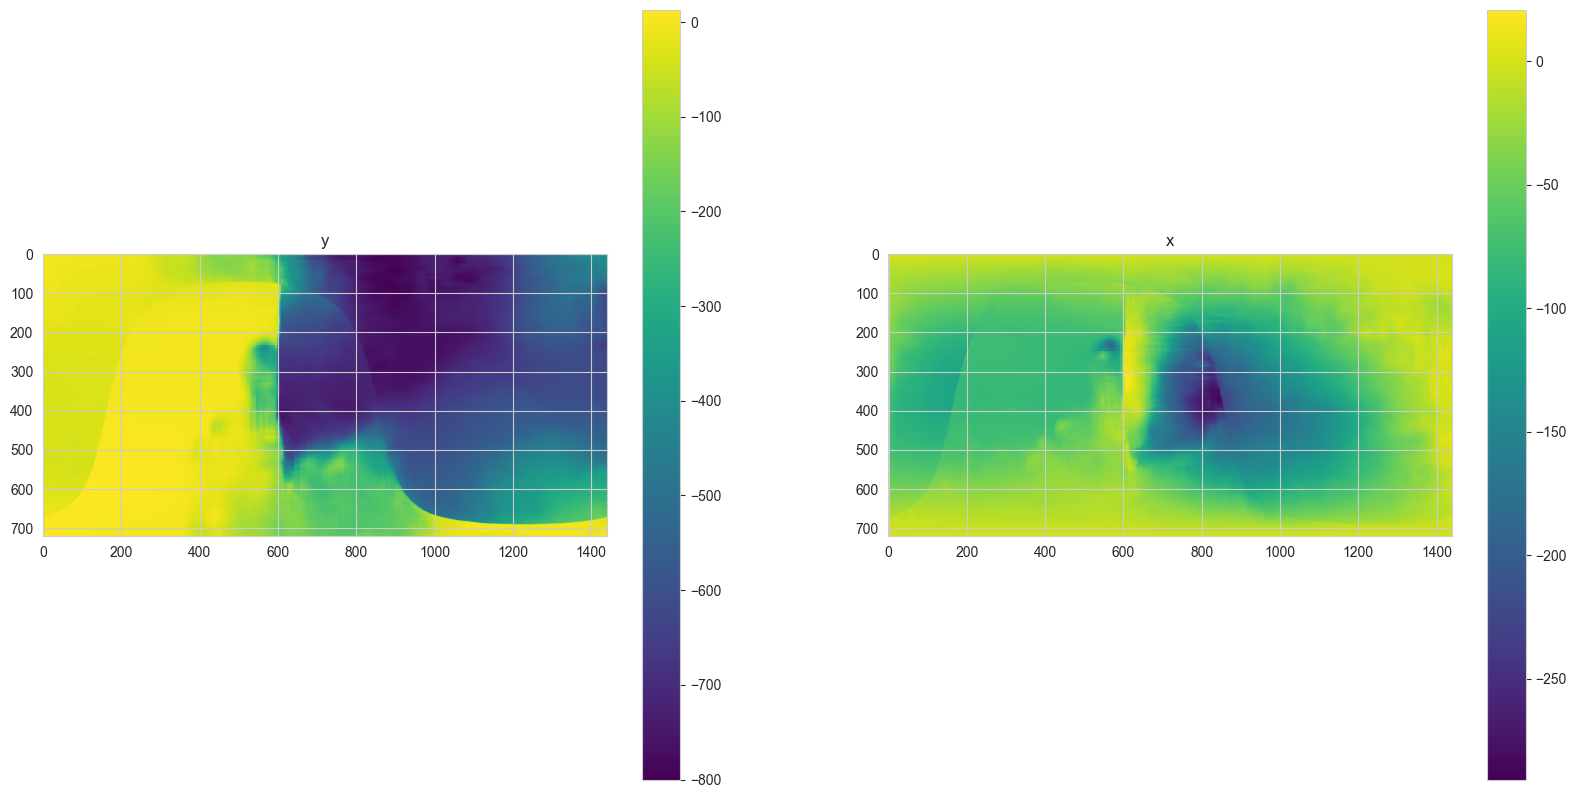

In [4]:
fig, axs = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)

img = axs[0].imshow(unfiltered_raft_speeds[0, 1, :, :], cmap="viridis")
axs[0].set(title='y')
plt.colorbar(img, ax=axs[0])

img = axs[1].imshow(unfiltered_raft_speeds[0, 0, :, :], cmap="viridis")
axs[1].set(title='x')

plt.colorbar(img, ax=axs[1])
plt.show()

In [9]:
# Фильтрация скоростей (занулить области, не отснятые камерой и неадекватные скорости)

filtered_raft_speeds = []

for i in range(len(unfiltered_raft_speeds)):
    data = np.copy(unfiltered_raft_speeds[i])
    # img_1 = np.array(imageio.imread(f'r0137_jpg/small/uvi_20200107_{i}.jpg'))
    # img_2 = np.array(imageio.imread(f'r0137_jpg/small/uvi_20200107_{i+1}.jpg'))
    frame_1 = cv2.imread(f'r0137_jpg/small/uvi_20200107_{i}.jpg')
    frame_2 = cv2.imread(f'r0137_jpg/small/uvi_20200107_{i+1}.jpg')
    frame_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2GRAY)
    frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2GRAY)
    non_zero_1 = frame_1 != 0
    non_zero_2 = frame_2 != 0
    
    filtered_data = data
    filtered_data = filtered_data * [non_zero_1]* [non_zero_2]

    filtered_data *= (filtered_data[0] < 0)
    filtered_data *= (filtered_data[0] > -250)
    filtered_data *= ( abs(filtered_data[0] / (filtered_data[1] + 1e-10)) >= 3.5 )
    
    filtered_raft_speeds.append(filtered_data)
    # print(abs(filtered_data[0]) / (filtered_data[1] + 1e-10) >= 3.5)
    # print(filtered_data.shape)

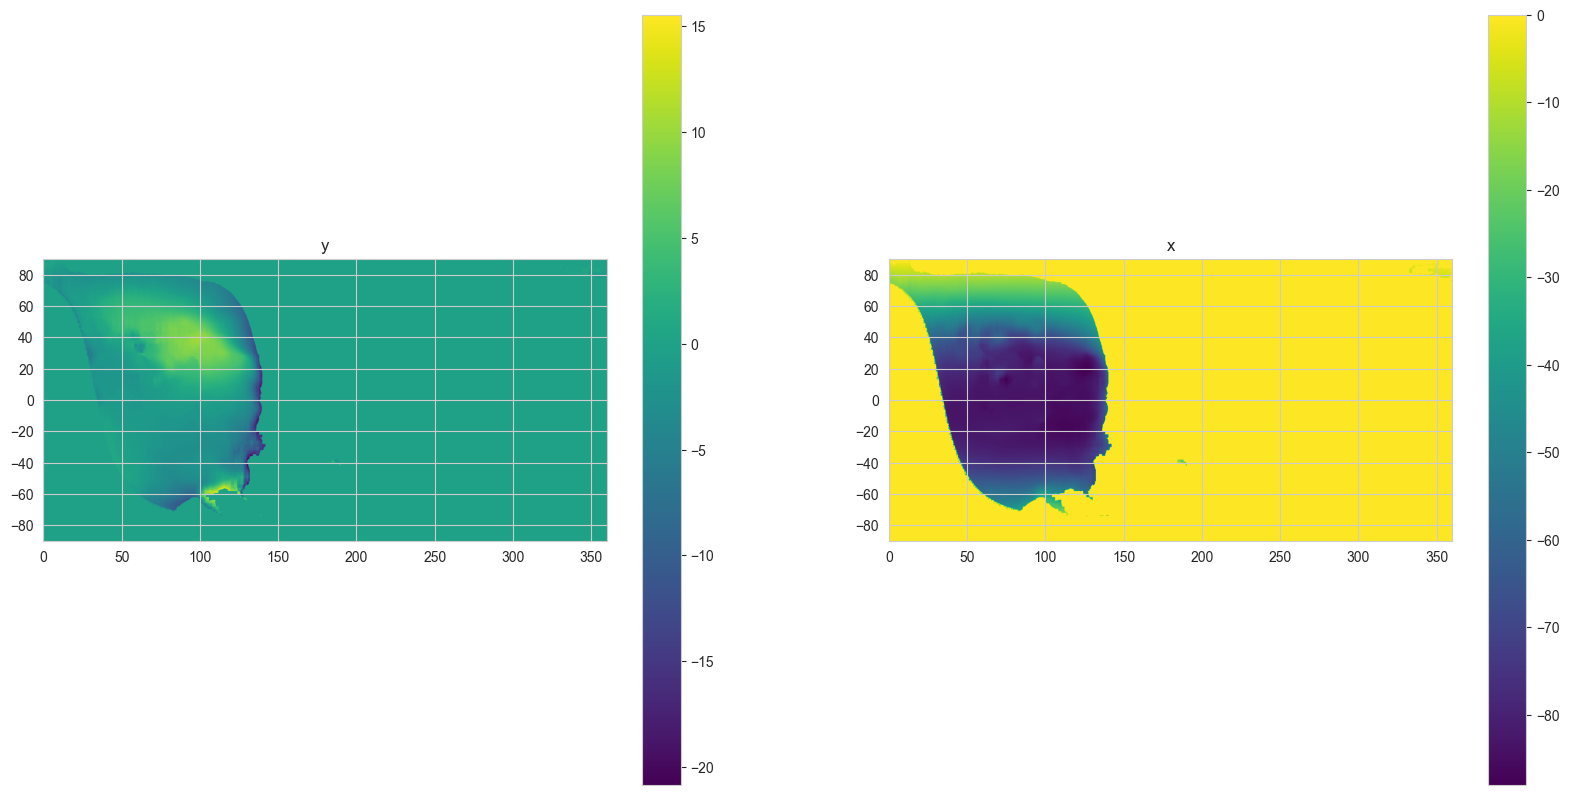

In [10]:
# проверяю на визуализации

fig, axs = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)

img = axs[0].imshow(filtered_raft_speeds[1][1], cmap="viridis", 
                  extent=[0, 360, -90, 90], origin='lower', aspect='equal')
axs[0].set(title='y')
plt.colorbar(img, ax=axs[0])

img = axs[1].imshow(filtered_raft_speeds[1][0], cmap="viridis", 
                  extent=[0, 360, -90, 90], origin='lower', aspect='equal')
axs[1].set(title='x')

plt.colorbar(img, ax=axs[1])
plt.show()

In [7]:
# Перевод в pd.dataframe, удаление нулей, перевод x,y (пиксели) координат в lamda,phi (градусы)

for i in range(len(filtered_raft_speeds)):
    speeds = np.copy(filtered_raft_speeds[i])
    dx = speeds[0]  # Значения dx
    dy = speeds[1]  # Значения dy
    
    # Создание координат
    x_coords = np.arange(1440)  # Координаты x
    y_coords = np.arange(720)    # Координаты y
    
    # Создание списка для хранения данных
    data = []
    
    # Заполнение данных
    for y in range(720):
        for x in range(1440):
            data.append([x_coords[x], y_coords[y], dx[y, x], dy[y, x]])
            
    # Создание DataFrame
    df = pd.DataFrame(data, columns=['lambda_1', 'phi_1', 'U', 'V'])
    
    
    # Перевод пиксельных координат в градусы
    df['lambda_1'] = df['lambda_1'] * (359.875 - 0.0625) / 1440 + 0.0625
    df['phi_1'] = df['phi_1'] * (89.9375 - (-89.9375)) / 720 - 89.9375
    
    # Фильтрация по нулям и значениям из другого полушария
    df = df[df['U'] != 0]
    df = df[df['V'] != 0]
    df = df[df['lambda_1'] < 150]
    
    # Сохранение DataFrame в CSV
    df.to_csv(f'RAFT/uvi_20200107_{i}-{i+1}.csv', index=False)


In [8]:
# Cобрать датасеты вместе в один
all_speeds = []
for i in range(11):#len(filtered_raft_speeds)):
    speeds = pd.read_csv(f'RAFT/uvi_20200107_{i}-{i+1}.csv')
    speeds = df.sort_values(by=['lambda_1', 'phi_1'])

    speeds['lambda_1'] = speeds['lambda_1'].apply(lambda v: round(v, 4))
    speeds['phi_1'] = speeds['phi_1'].apply(lambda v: round(v, 4))

    all_speeds.append(speeds)  

combined_speeds = pd.concat(all_speeds, ignore_index=True)
combined_speeds

,lambda_1,phi_1,U,V
0,0.0625,57.4601,-30.785921,-7.336183
1,0.0625,57.7099,-37.511276,-2.289136
2,0.0625,57.9597,-38.784470,-1.949296
3,0.0625,58.2095,-38.703030,-1.640469
4,0.0625,58.4594,-38.398602,-1.623822
...,...,...,...,...
3011102,133.7428,0.7495,-62.910126,-17.594101
3011103,133.7428,0.9993,-62.881638,-17.094564
3011104,133.7428,1.2491,-62.922974,-16.684076
3011105,133.7428,1.4990,-62.868557,-16.230844


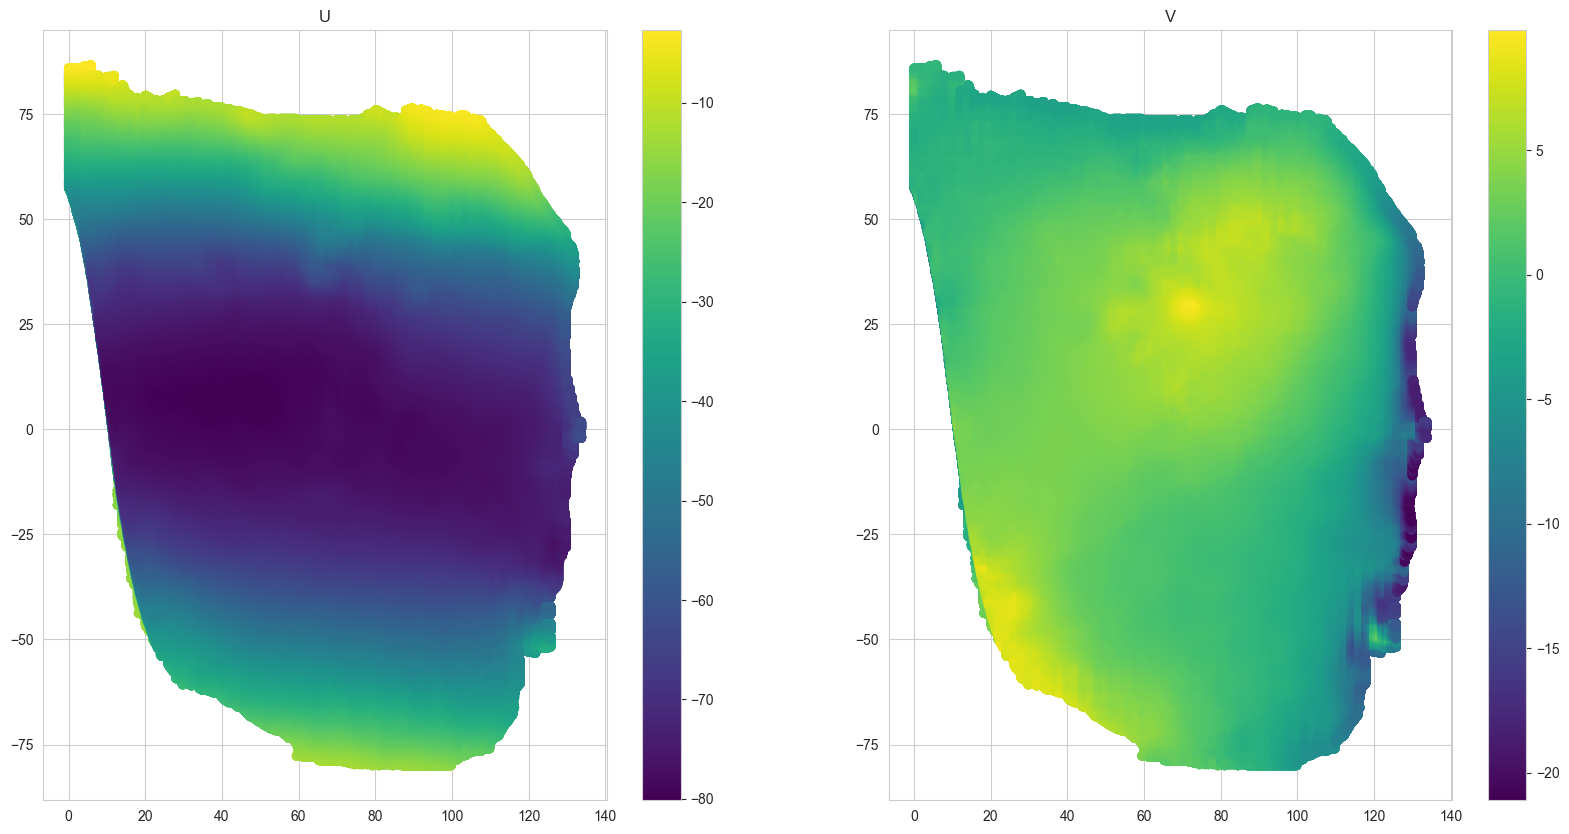

In [9]:
# Создание подграфиков
fig, axs = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)

# Построение графика для U
sc1 = axs[0].scatter(combined_speeds['lambda_1'], combined_speeds['phi_1'], c=combined_speeds['U'], cmap='viridis', marker='o')
axs[0].set(title='U')
plt.colorbar(sc1, ax=axs[0])

# Построение графика для V
sc2 = axs[1].scatter(combined_speeds['lambda_1'], combined_speeds['phi_1'], c=combined_speeds['V'], cmap='viridis', marker='o')
axs[1].set(title='V')

plt.colorbar(sc2, ax=axs[1])
plt.show()

In [10]:
# Посчитать средние скорости
def rolling_mean(speeds_df, window_size=10, step_size=5):
    speeds_df = speeds_df.sort_values(by='phi_1').reset_index()

    center_phi = speeds_df['phi_1'].iloc[0]

    phi_means = []

    u_means = []
    v_means = []
    u_sds = []
    v_sds = []
    u_sems = []
    v_sems = []

    while center_phi <= speeds_df['phi_1'].iloc[-1]:
        left_bound = center_phi - window_size / 2
        right_bound = center_phi + window_size / 2

        in_window = (speeds_df['phi_1'] >= left_bound) & (speeds_df['phi_1'] <= right_bound)

        phi_means.append(speeds_df.loc[in_window, 'phi_1'].mean())

        u_means.append(speeds_df.loc[in_window, 'U'].mean())
        v_means.append(speeds_df.loc[in_window, 'V'].mean())

        u_sds.append(speeds_df.loc[in_window, 'U'].std())
        v_sds.append(speeds_df.loc[in_window, 'V'].std())
        u_sems.append(speeds_df.loc[in_window, 'U'].sem())
        v_sems.append(speeds_df.loc[in_window, 'V'].sem())

        center_phi += step_size

    result_df = pd.DataFrame({
        'phi_mean': phi_means,
        'u_mean': u_means,
        'v_mean': v_means,
        'u_sd': u_sds,
        'v_sd': v_sds,
        'u_sem': u_sems,
        'v_sem': v_sems
    })

    return result_df, speeds_df

rolling_mean_df = rolling_mean(combined_speeds)

In [11]:
# Загрузить средние из корр. метода
corr_results_df = pd.read_csv("Mean speeds/classic_result_df.csv")
corr_speeds_df = pd.read_csv("Mean speeds/classic_speeds_df.csv")

corr_rolling_mean_df = corr_results_df, corr_speeds_df

In [12]:
# Построил графики средних скоростей
def plot_rolling_mean(rolling_mean_df, corr_rolling_mean_df, file_paths, figure):
    plt.rcParams['font.size'] = 14

    result_df, speeds_df = rolling_mean_df
    corr_results_df, corr_speeds_df = corr_rolling_mean_df

    # Создаем первый график для u_mean
    ax = figure.add_subplot(121)
    ax.plot(result_df['phi_mean'], result_df['u_mean'], marker='s', lw=3, color='deepskyblue', label='U RAFT')  # Основная линия
    ax.errorbar(result_df['phi_mean'], result_df['u_mean'], yerr=3*result_df['u_sem'], linestyle='None',
                ecolor='navy', capsize=3, lw=2)
    
    # Добавляем коррелированные данные
    ax.plot(corr_results_df['phi_mean'], corr_results_df['u_mean'], marker='o', lw=3, color='orange', label='U Корреляционный')  # Корр. линия
    ax.errorbar(corr_results_df['phi_mean'], corr_results_df['u_mean'], yerr=3*corr_results_df['u_sem'], linestyle='None',
                ecolor='darkorange', capsize=3, lw=2)

    ax.set_xlabel('Широта, градусы')
    ax.set_ylabel('Зональная скорость, м/с')
    ax.set_xticks(np.arange(-60, 90, 10))
    ax.invert_yaxis()
    ax.grid(True)  # Added grid
    ax.legend()  # Добавляем легенду

    # Создаем второй график для v_mean
    ax2 = figure.add_subplot(122)
    ax2.plot(result_df['phi_mean'], result_df['v_mean'], marker='s', lw=3, color='orangered', label='V RAFT')  # Основная линия
    ax2.errorbar(result_df['phi_mean'], result_df['v_mean'], yerr=3*result_df['v_sem'], linestyle='None',
                  ecolor='maroon', capsize=3, lw=2)
    
    # Добавляем коррелированные данные
    ax2.plot(corr_results_df['phi_mean'], corr_results_df['v_mean'], marker='o', lw=3, color='limegreen', label='V Корреляционный')  # Корр. линия
    ax2.errorbar(corr_results_df['phi_mean'], corr_results_df['v_mean'], yerr=3*corr_results_df['v_sem'], linestyle='None',
                  ecolor='darkgreen', capsize=3, lw=2)

    ax2.set_xlabel('Широта, градусы')
    ax2.set_ylabel('Меридиональная скорость, м/с')
    ax2.set_xticks(np.arange(-60, 90, 10))
    ax2.grid(True)  # Added grid
    ax2.legend()  # Добавляем легенду

    # Сохранение графика в подпапке
    folder_path = os.path.join(os.path.dirname(file_paths), "mean speeds")
    os.makedirs(folder_path, exist_ok=True)
    file_name = "combined mean speeds.png"
    file_path = os.path.join(folder_path, file_name)
    figure.savefig(file_path)

    plt.tight_layout()
    figure.canvas.draw()

# Использование функции
fig = plt.Figure(figsize=(20, 10))
plot_rolling_mean(rolling_mean_df, corr_rolling_mean_df, "Mean speeds", fig)


<Figure size 640x480 with 0 Axes>

In [13]:
# Делаем сетку для origin

def create_grid_df_for_origin(speeds_results):  # Сюда вставить combined_speeds
    # # figure = plt.figure(figsize=(10, 10))
    # ax = figure.add_subplot(111)
    
    lambda_values = speeds_results['lambda_1']
    phi_values = speeds_results['phi_1']
    u_values = speeds_results['U']
    v_values = speeds_results['V']

    # Преобразование данных в сетку
    lambda_grid, phi_grid = np.mgrid[np.min(lambda_values):np.max(lambda_values):5,
                            np.min(phi_values):np.max(phi_values):5]
    lambda_grid += 2.5  # Сдвигаем координаты на половину шага сетки
    phi_grid += 2.5  # Сдвигаем координаты на половину шага сетки
    u_grid = np.zeros_like(lambda_grid)
    v_grid = np.zeros_like(phi_grid)
    count_grid = np.zeros_like(lambda_grid)

    # Усреднение векторов в каждом квадрате 5x5
    for i in range(lambda_grid.shape[0]):
        for j in range(lambda_grid.shape[1]):
            mask = (lambda_values >= lambda_grid[i, j] - 2.5) & (lambda_values < lambda_grid[i, j] + 2.5) & (
                        phi_values >= phi_grid[i, j] - 2.5) & (phi_values < phi_grid[i, j] + 2.5)
            u_grid[i, j] = np.mean(u_values[mask])
            v_grid[i, j] = np.mean(v_values[mask])
            count_grid[i, j] = np.sum(mask)

    # grid_df = pd.DataFrame('lambda_grid': lambda_grid)
    # grid_df = grid_df.assign(lambda_grid = lambda_grid)
    print(lambda_grid, '\n\n')
    print(phi_grid, '\n\n')
    print(u_grid, '\n\n')
    print(v_grid)
    #
    # lambda_grid = [list(item) for sublist in lambda_grid for item in sublist]
    # phi_grid = [list(item) for sublist in phi_grid for item in sublist]
    # u_grid = [list(item) for sublist in u_grid for item in sublist]
    # v_grid = [list(item) for sublist in v_grid for item in sublist]

    # создание датафрейма
    grid_df = pd.DataFrame({
        'lambda': lambda_grid.ravel(),
        'phi': phi_grid.ravel(),
        'u': u_grid.ravel(),
        'v': v_grid.ravel(),
    })
    print(grid_df)
    grid_df.to_csv('grid_df_raft.csv', index=False, sep=';')
    
create_grid_df_for_origin(combined_speeds)

[[  2.5625   2.5625   2.5625   2.5625   2.5625   2.5625   2.5625   2.5625
    2.5625   2.5625   2.5625   2.5625   2.5625   2.5625   2.5625   2.5625
    2.5625   2.5625   2.5625   2.5625   2.5625   2.5625   2.5625   2.5625
    2.5625   2.5625   2.5625   2.5625   2.5625   2.5625   2.5625   2.5625
    2.5625   2.5625]
 [  7.5625   7.5625   7.5625   7.5625   7.5625   7.5625   7.5625   7.5625
    7.5625   7.5625   7.5625   7.5625   7.5625   7.5625   7.5625   7.5625
    7.5625   7.5625   7.5625   7.5625   7.5625   7.5625   7.5625   7.5625
    7.5625   7.5625   7.5625   7.5625   7.5625   7.5625   7.5625   7.5625
    7.5625   7.5625]
 [ 12.5625  12.5625  12.5625  12.5625  12.5625  12.5625  12.5625  12.5625
   12.5625  12.5625  12.5625  12.5625  12.5625  12.5625  12.5625  12.5625
   12.5625  12.5625  12.5625  12.5625  12.5625  12.5625  12.5625  12.5625
   12.5625  12.5625  12.5625  12.5625  12.5625  12.5625  12.5625  12.5625
   12.5625  12.5625]
 [ 17.5625  17.5625  17.5625  17.5625  17.5625  1

In [52]:
unfiltered_raft_speeds_w = np.load('RAFT/unfiltered_raft_frames_test_wavelets.npy')
unfiltered_raft_speeds_w.shape
len(unfiltered_raft_speeds_w)

4

In [53]:
"""
Проверка перевода из dx, dy в скорости.
Строю график rolling mean по dx, dy, фильтрую по координатам - вроде, все верно.

Проверка вейвлетов - заменил unfiltered_raft_frames
"""

filtered_raft_speeds_ = []

for i in range(len(unfiltered_raft_speeds_w)):
    data = np.copy(unfiltered_raft_speeds_w[i])
    # img_1 = np.array(imageio.imread(f'r0137_jpg/small/uvi_20200107_{i}.jpg'))
    # img_2 = np.array(imageio.imread(f'r0137_jpg/small/uvi_20200107_{i+1}.jpg'))
    frame_1 = cv2.imread(f'r0137_jpg/small/uvi_20200107_{i}.jpg')
    frame_2 = cv2.imread(f'r0137_jpg/small/uvi_20200107_{i+1}.jpg')
    frame_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2GRAY)
    frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2GRAY)
    non_zero_1 = frame_1 != 0
    non_zero_2 = frame_2 != 0
    
    filtered_data = data
    # filtered_data = filtered_data * [non_zero_1]* [non_zero_2]
    
    filtered_raft_speeds_.append(filtered_data)

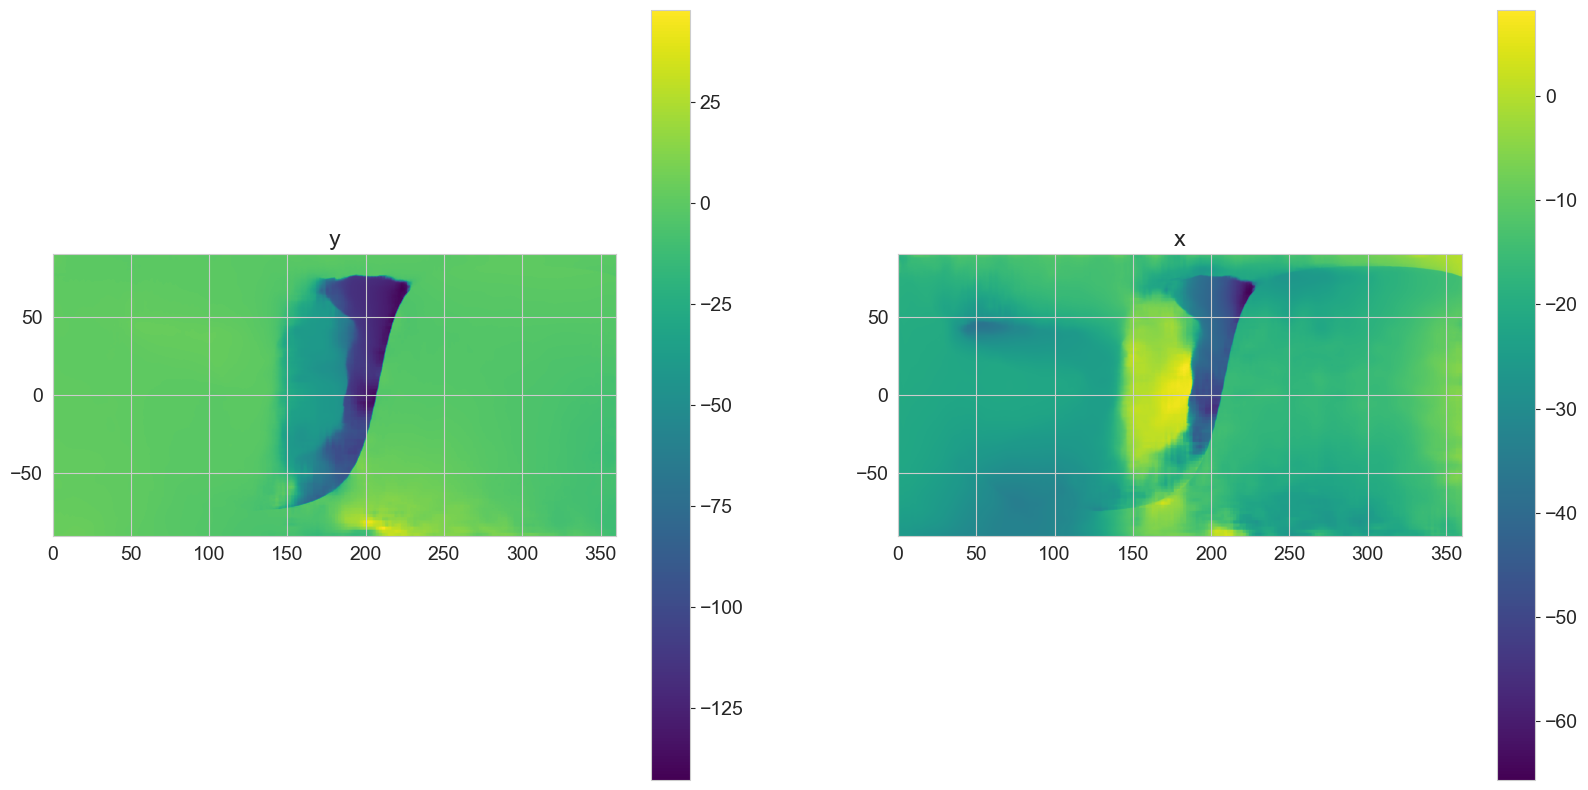

In [54]:
fig, axs = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)

img = axs[0].imshow(filtered_raft_speeds_[1][1], cmap="viridis", 
                  extent=[0, 360, -90, 90], origin='lower', aspect='equal')
axs[0].set(title='y')
plt.colorbar(img, ax=axs[0])

img = axs[1].imshow(filtered_raft_speeds_[1][0], cmap="viridis", 
                  extent=[0, 360, -90, 90], origin='lower', aspect='equal')
axs[1].set(title='x')

plt.colorbar(img, ax=axs[1])
plt.show()

In [55]:
# Перевод в pd.dataframe, удаление нулей, перевод x,y (пиксели) координат в lamda,phi (градусы)

for i in range(len(filtered_raft_speeds_)):
    speeds = np.copy(filtered_raft_speeds_[i])
    dx = speeds[0]  # Значения dx
    dy = speeds[1]  # Значения dy
    
    # Создание координат
    x_coords = np.arange(1440)  # Координаты x
    y_coords = np.arange(720)    # Координаты y
    
    # Создание списка для хранения данных
    data = []
    
    # Заполнение данных
    for y in range(720):
        for x in range(1440):
            data.append([x_coords[x], y_coords[y], dx[y, x], dy[y, x]])
            
    # Создание DataFrame
    df = pd.DataFrame(data, columns=['lambda_1', 'phi_1', 'U', 'V'])
    
    
    # Перевод пиксельных координат в градусы
    df['lambda_1'] = df['lambda_1'] * (359.875 - 0.0625) / 1440 + 0.0625
    df['phi_1'] = df['phi_1'] * (89.9375 - (-89.9375)) / 720 - 89.9375
    
    # Фильтрация по нулям и значениям из другого полушария
    df = df[df['U'] != 0]
    df = df[df['V'] != 0]
    df = df[df['lambda_1'] < 150]
    df = df[df['lambda_1'] > 50]
    df = df[df['phi_1'] < 50]
    df = df[df['phi_1'] > -50]



    
    # Сохранение DataFrame в CSV
    df.to_csv(f'RAFT/test_uvi_20200107_{i}-{i+1}.csv', index=False)

In [56]:
# Cобрать датасеты вместе в один
all_speeds_ = []
for i in range(11):#len(filtered_raft_speeds)):
    speeds = pd.read_csv(f'RAFT/test_uvi_20200107_{i}-{i+1}.csv')
    speeds = df.sort_values(by=['lambda_1', 'phi_1'])

    speeds['lambda_1'] = speeds['lambda_1'].apply(lambda v: round(v, 4))
    speeds['phi_1'] = speeds['phi_1'].apply(lambda v: round(v, 4))

    all_speeds_.append(speeds)  

combined_speeds_ = pd.concat(all_speeds, ignore_index=True)
combined_speeds_

,lambda_1,phi_1,U,V
0,0.0625,57.4601,-30.785921,-7.336183
1,0.0625,57.7099,-37.511276,-2.289136
2,0.0625,57.9597,-38.784470,-1.949296
3,0.0625,58.2095,-38.703030,-1.640469
4,0.0625,58.4594,-38.398602,-1.623822
...,...,...,...,...
3011102,133.7428,0.7495,-62.910126,-17.594101
3011103,133.7428,0.9993,-62.881638,-17.094564
3011104,133.7428,1.2491,-62.922974,-16.684076
3011105,133.7428,1.4990,-62.868557,-16.230844


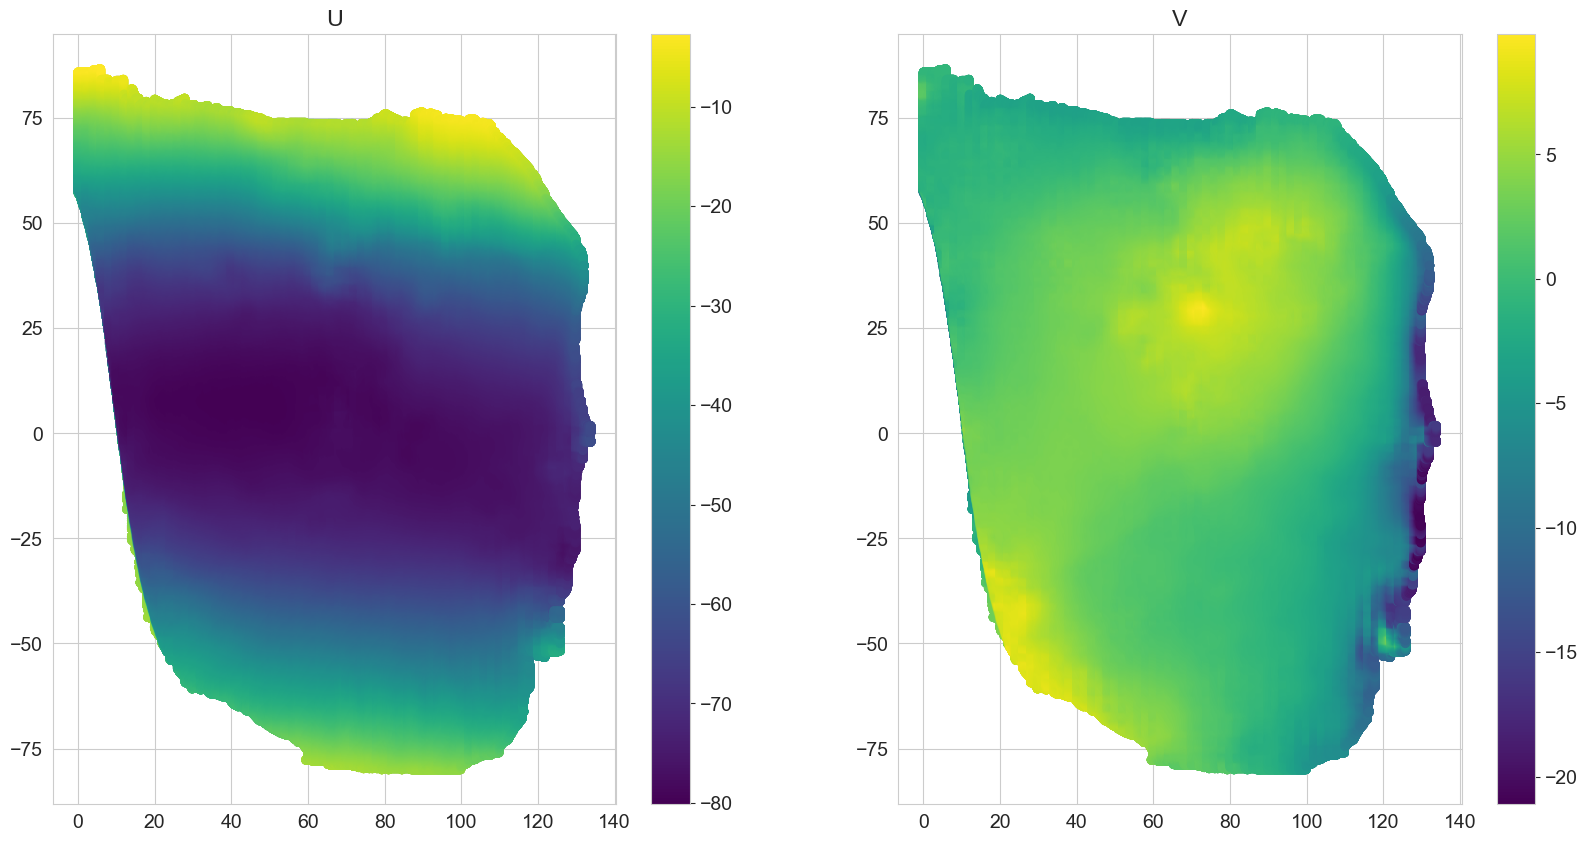

In [57]:
# Создание подграфиков
fig, axs = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)

# Построение графика для U
sc1 = axs[0].scatter(combined_speeds_['lambda_1'], combined_speeds_['phi_1'], c=combined_speeds_['U'], cmap='viridis', marker='o')
axs[0].set(title='U')
plt.colorbar(sc1, ax=axs[0])

# Построение графика для V
sc2 = axs[1].scatter(combined_speeds_['lambda_1'], combined_speeds_['phi_1'], c=combined_speeds_['V'], cmap='viridis', marker='o')
axs[1].set(title='V')

plt.colorbar(sc2, ax=axs[1])
plt.show()

In [58]:
# Посчитать средние скорости
def rolling_mean(speeds_df, window_size=10, step_size=5):
    speeds_df = speeds_df.sort_values(by='phi_1').reset_index()

    center_phi = speeds_df['phi_1'].iloc[0]

    phi_means = []

    u_means = []
    v_means = []
    u_sds = []
    v_sds = []
    u_sems = []
    v_sems = []

    while center_phi <= speeds_df['phi_1'].iloc[-1]:
        left_bound = center_phi - window_size / 2
        right_bound = center_phi + window_size / 2

        in_window = (speeds_df['phi_1'] >= left_bound) & (speeds_df['phi_1'] <= right_bound)

        phi_means.append(speeds_df.loc[in_window, 'phi_1'].mean())

        u_means.append(speeds_df.loc[in_window, 'U'].mean())
        v_means.append(speeds_df.loc[in_window, 'V'].mean())

        u_sds.append(speeds_df.loc[in_window, 'U'].std())
        v_sds.append(speeds_df.loc[in_window, 'V'].std())
        u_sems.append(speeds_df.loc[in_window, 'U'].sem())
        v_sems.append(speeds_df.loc[in_window, 'V'].sem())

        center_phi += step_size

    result_df = pd.DataFrame({
        'phi_mean': phi_means,
        'u_mean': u_means,
        'v_mean': v_means,
        'u_sd': u_sds,
        'v_sd': v_sds,
        'u_sem': u_sems,
        'v_sem': v_sems
    })

    return result_df, speeds_df

rolling_mean_df = rolling_mean(combined_speeds_)

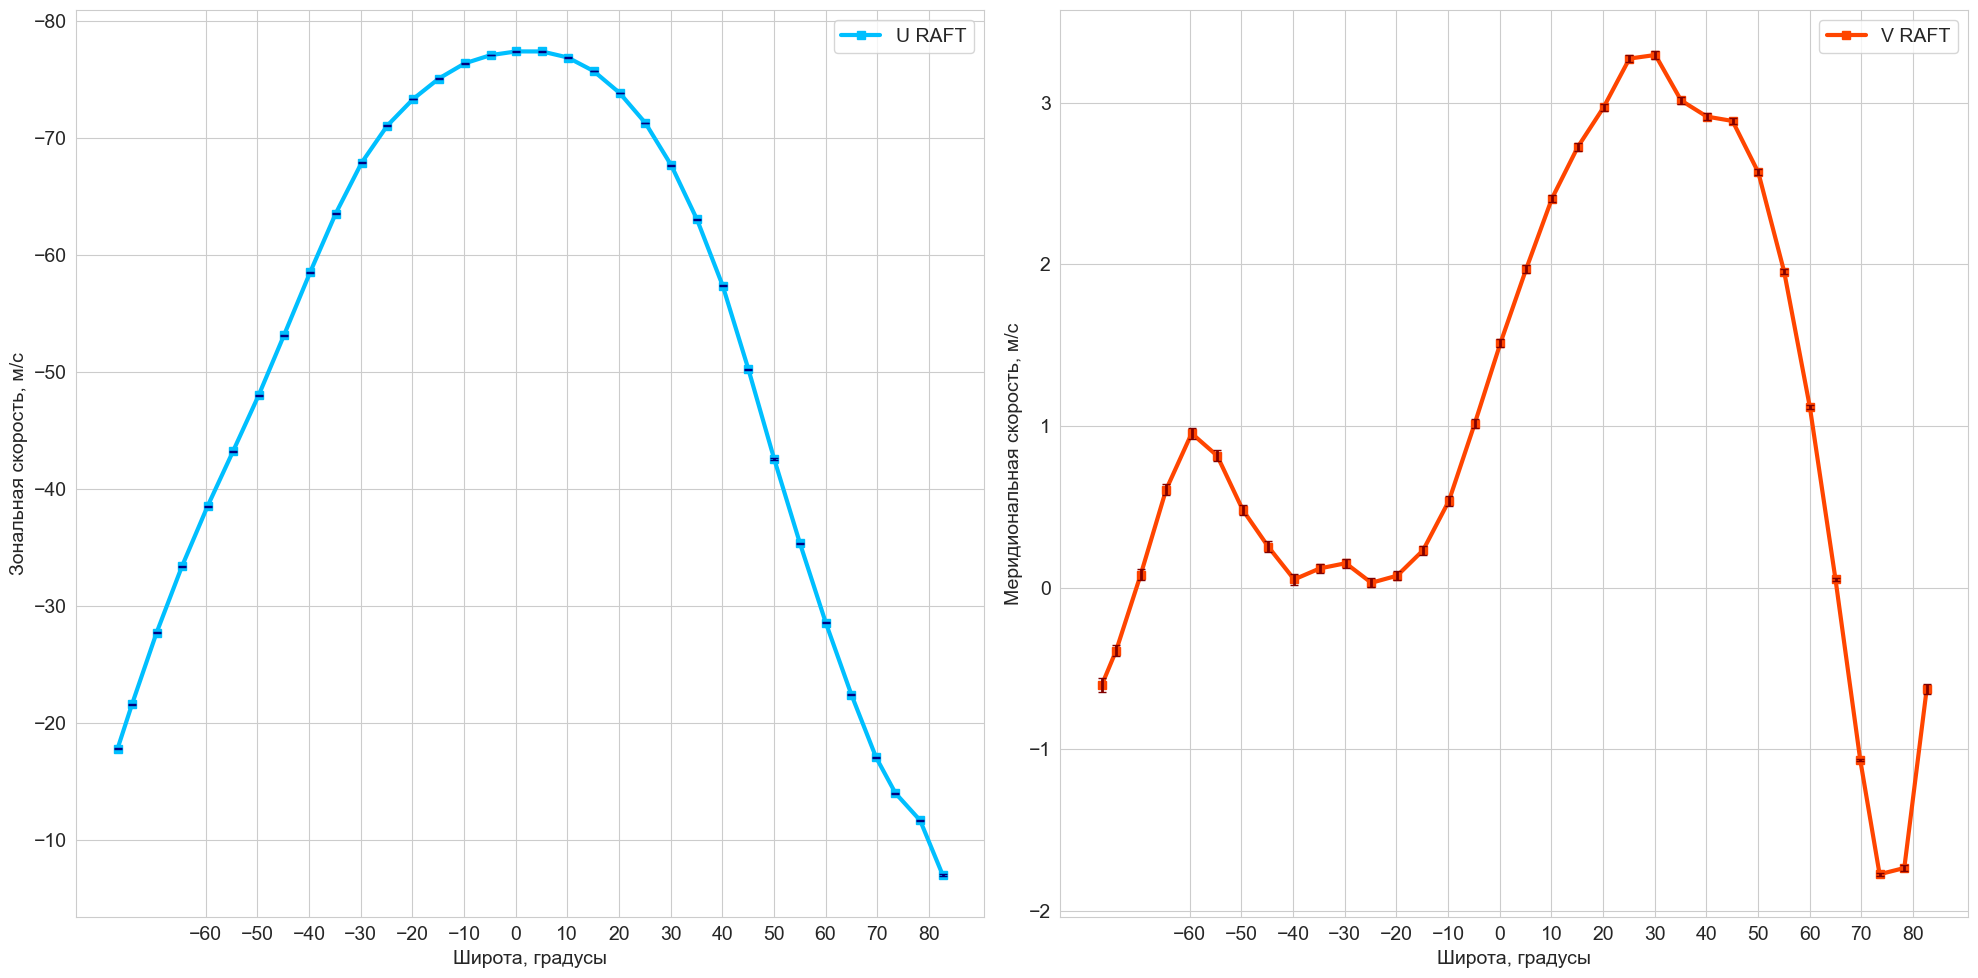

In [59]:
# Построил графики средних скоростей
def plot_rolling_mean(rolling_mean_df, file_paths):
    plt.rcParams['font.size'] = 14

    result_df, speeds_df = rolling_mean_df

    # Создаем фигуру с двумя подграфиками
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Создаем первый график для u_mean
    ax.plot(result_df['phi_mean'], result_df['u_mean'], marker='s', lw=3, color='deepskyblue', label='U RAFT')  # Основная линия
    ax.errorbar(result_df['phi_mean'], result_df['u_mean'], yerr=3*result_df['u_sem'], linestyle='None',
                ecolor='navy', capsize=3, lw=2)

    ax.set_xlabel('Широта, градусы')
    ax.set_ylabel('Зональная скорость, м/с')
    ax.set_xticks(np.arange(-60, 90, 10))
    ax.invert_yaxis()
    ax.grid(True)  # Добавляем сетку
    ax.legend()  # Добавляем легенду

    # Создаем второй график для v_mean
    ax2.plot(result_df['phi_mean'], result_df['v_mean'], marker='s', lw=3, color='orangered', label='V RAFT')  # Основная линия
    ax2.errorbar(result_df['phi_mean'], result_df['v_mean'], yerr=3*result_df['v_sem'], linestyle='None',
                  ecolor='maroon', capsize=3, lw=2)

    ax2.set_xlabel('Широта, градусы')
    ax2.set_ylabel('Меридиональная скорость, м/с')
    ax2.set_xticks(np.arange(-60, 90, 10))
    ax2.grid(True)  # Добавляем сетку
    ax2.legend()  # Добавляем легенду

    plt.tight_layout()
    plt.show()  # Вывод графика на экран вместо сохранения


# Использование функции
plot_rolling_mean(rolling_mean_df, "Mean speeds")
